**Facebook Open Source Prophet: Automatic Forecasting Procedure**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [62]:
import fbprophet
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plta
from fbprophet import Prophet

plt.style.use('default')

In [37]:
market = 'BTC-GBP'
granularity = 3600

In [44]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [45]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity / 60))
    new_start = df['date'].min() - timedelta(hours=300)
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [78]:
df = getHistoricalDataChained(market, granularity, 30) # 1 year
df.shape

(8998, 7)

In [79]:
df.head()

,date,low,high,open,close,volume,adj close
0,2020-06-06 23:00:00,7627.91,7678.45,7632.16,7655.78,10.964309,7655.78
1,2020-06-07 00:00:00,7618.97,7655.58,7655.58,7654.98,7.324231,7654.98
2,2020-06-07 01:00:00,7631.98,7661.72,7657.83,7646.62,3.294689,7646.62
3,2020-06-07 02:00:00,7638.81,7679.36,7638.81,7660.20,2.277896,7660.20
4,2020-06-07 03:00:00,7654.14,7675.80,7658.63,7663.75,1.543305,7663.75


In [80]:
df1 = df[[ 'date','adj close' ]]
df1.columns = [ 'ds', 'y' ]
df1.head()

,ds,y
0,2020-06-06 23:00:00,7655.78
1,2020-06-07 00:00:00,7654.98
2,2020-06-07 01:00:00,7646.62
3,2020-06-07 02:00:00,7660.20
4,2020-06-07 03:00:00,7663.75


In [81]:
model = Prophet()
model.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [85]:
future = model.make_future_dataframe(48) # 48 hours ahead
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-06 23:00:00,7565.791114,5319.774803,10062.120416,7565.791114,7565.791114,77.228665,77.228665,77.228665,11.729853,11.729853,11.729853,65.498812,65.498812,65.498812,0.0,0.0,0.0,7643.019779
1,2020-06-07 00:00:00,7565.556541,5345.324225,9906.397688,7565.556541,7565.556541,66.002971,66.002971,66.002971,7.463979,7.463979,7.463979,58.538992,58.538992,58.538992,0.0,0.0,0.0,7631.559512
2,2020-06-07 01:00:00,7565.321968,5293.200608,9834.238220,7565.321968,7565.321968,45.756129,45.756129,45.756129,-5.460510,-5.460510,-5.460510,51.216639,51.216639,51.216639,0.0,0.0,0.0,7611.078097
3,2020-06-07 02:00:00,7565.087395,5249.296486,9730.536436,7565.087395,7565.087395,18.979735,18.979735,18.979735,-24.631415,-24.631415,-24.631415,43.611150,43.611150,43.611150,0.0,0.0,0.0,7584.067130
4,2020-06-07 03:00:00,7564.852822,5333.781116,9867.714819,7564.852822,7564.852822,-5.781306,-5.781306,-5.781306,-41.584651,-41.584651,-41.584651,35.803345,35.803345,35.803345,0.0,0.0,0.0,7559.071516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,2021-07-30 22:00:00,11402.038606,-1709.265392,24222.890713,-1695.769550,24522.714010,17.214856,17.214856,17.214856,10.598632,10.598632,10.598632,6.616224,6.616224,6.616224,0.0,0.0,0.0,11419.253462
9042,2021-07-31 22:00:00,11117.358801,-1655.129697,25061.771856,-2239.906404,24627.087248,82.617697,82.617697,82.617697,10.598632,10.598632,10.598632,72.019065,72.019065,72.019065,0.0,0.0,0.0,11199.976498
9043,2021-08-01 22:00:00,10832.678997,-3127.300459,24830.873742,-2870.052738,24838.636438,-51.144141,-51.144141,-51.144141,10.598632,10.598632,10.598632,-61.742773,-61.742773,-61.742773,0.0,0.0,0.0,10781.534856
9044,2021-08-02 22:00:00,10547.999193,-4543.918957,24768.732275,-3576.583112,24936.734946,1.868555,1.868555,1.868555,10.598632,10.598632,10.598632,-8.730078,-8.730078,-8.730078,0.0,0.0,0.0,10549.867747


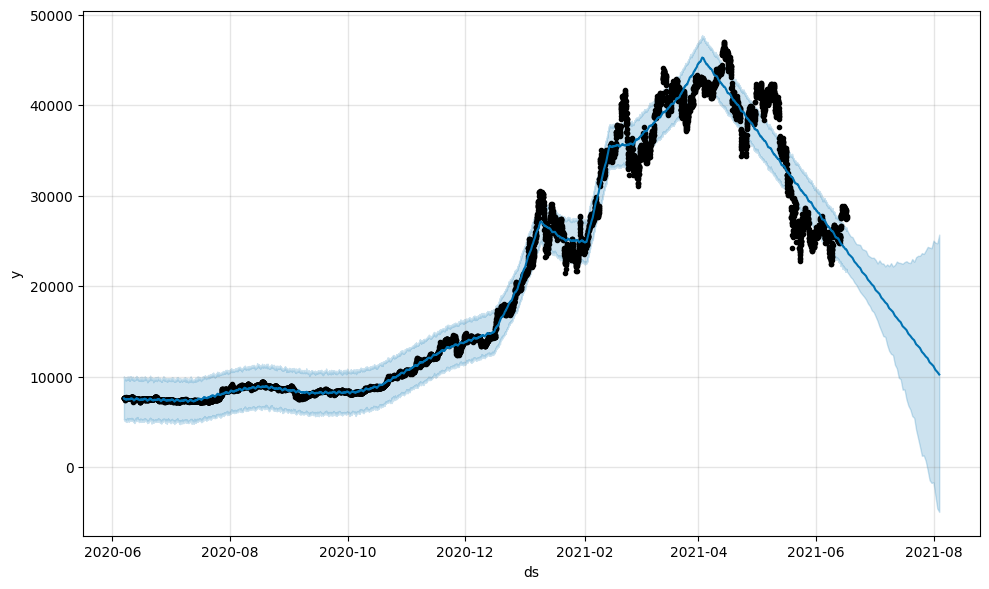

In [86]:
model.plot(forecast)
plt.show()

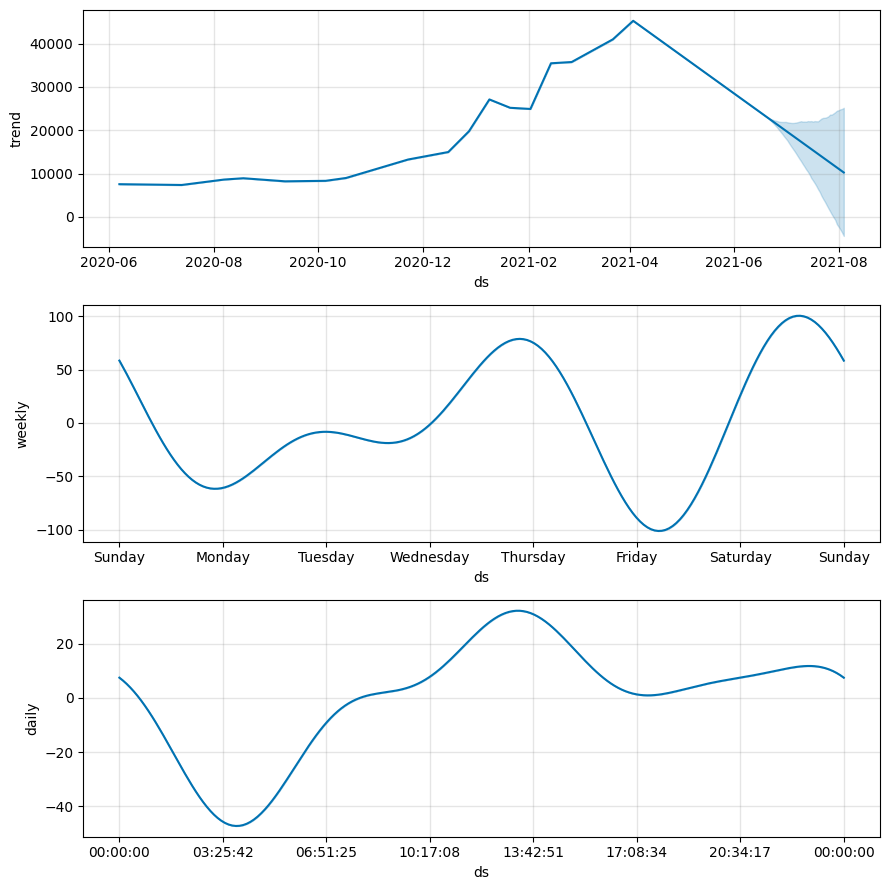

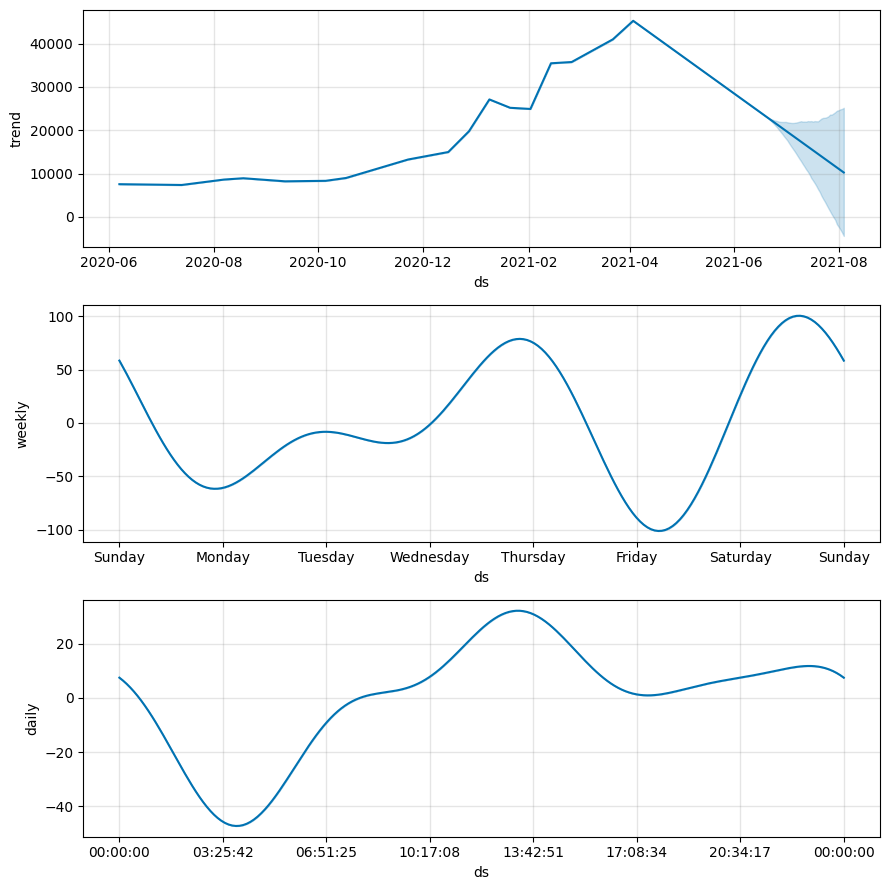

In [87]:
model.plot_components(forecast)